In [1]:
# To guarantee repeatability with Keras
seed_value = 4720

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, plot_roc_curve, confusion_matrix, plot_confusion_matrix 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from tensorflow.random import set_seed

# Data Pre-processing and Feature Preparation

In [3]:
# Import dataset
data_orig = pd.read_csv('../input/project-data-ee4c12-set-pv/Project_Data_EE4C12_SET_PV.csv')
data_orig

,Irradiance,Ambient_Temperature,Sun_Azimuth,Sun_Elevation,System_Power,System_Age,System_Status,Fault_Type
0,713,3.8,-71.3,19.8,5000.000000,0.073277,0,0
1,152,2.7,-28.2,11.7,1290.467722,3.731482,0,0
2,75,4.5,-49.6,23.1,366.571466,0.236534,0,0
3,379,17.7,-46.3,45.3,2261.488687,1.720781,0,0
4,453,14.2,-107.2,15.9,2616.082381,0.674352,0,0
...,...,...,...,...,...,...,...,...
11995,62,10.2,-17.2,13.3,118.293683,13.476348,1,3
11996,114,14.8,-17.4,33.2,253.335320,4.542954,1,3
11997,144,6.1,41.2,6.4,526.328072,14.553955,1,3
11998,486,9.6,56.1,14.8,1707.208551,6.610661,1,3


In [4]:
# Dataset transformation using one-hot encoding for multi-class classification

data = data_orig.drop('Fault_Type', axis=1) # remove the ordinary encoding column
data['Healthy'] = np.where(data_orig['Fault_Type'] == 0, 1, 0)
data['Short_Circuit'] = np.where(data_orig['Fault_Type'] == 1, 1, 0)
data['Broken_Cells'] = np.where(data_orig['Fault_Type'] == 2, 1, 0)
data['Broken_Strings'] = np.where(data_orig['Fault_Type'] == 3, 1, 0)
data

,Irradiance,Ambient_Temperature,Sun_Azimuth,Sun_Elevation,System_Power,System_Age,System_Status,Healthy,Short_Circuit,Broken_Cells,Broken_Strings
0,713,3.8,-71.3,19.8,5000.000000,0.073277,0,1,0,0,0
1,152,2.7,-28.2,11.7,1290.467722,3.731482,0,1,0,0,0
2,75,4.5,-49.6,23.1,366.571466,0.236534,0,1,0,0,0
3,379,17.7,-46.3,45.3,2261.488687,1.720781,0,1,0,0,0
4,453,14.2,-107.2,15.9,2616.082381,0.674352,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,62,10.2,-17.2,13.3,118.293683,13.476348,1,0,0,0,1
11996,114,14.8,-17.4,33.2,253.335320,4.542954,1,0,0,0,1
11997,144,6.1,41.2,6.4,526.328072,14.553955,1,0,0,0,1
11998,486,9.6,56.1,14.8,1707.208551,6.610661,1,0,0,0,1


In [5]:
print('Dataset dimention: ', data.shape)
if data.isnull().values.any():
    print('Some values are missing')
else:
    print('Noo missing values')

Dataset dimention:  (12000, 11)
Noo missing values


In [6]:
# Training-testing sets split: from now on the testing set must not be part of any operation, in order to prevent data leak

training_set, testing_set = train_test_split(data, test_size=0.15, random_state=seed_value)

X_training = training_set[['Irradiance', 'Ambient_Temperature', 'Sun_Azimuth', 'Sun_Elevation', 
                              'System_Power', 'System_Age']]
y_2c_training = training_set['System_Status']
y_mc_training = training_set[['Healthy', 'Short_Circuit', 'Broken_Cells', 'Broken_Strings']]

X_test = testing_set[['Irradiance', 'Ambient_Temperature', 'Sun_Azimuth', 'Sun_Elevation', 
                              'System_Power', 'System_Age']]
y_2c_test = testing_set['System_Status']
y_mc_test = testing_set[['Healthy', 'Short_Circuit', 'Broken_Cells', 'Broken_Strings']]


In [7]:
#training_set

In [8]:
#testing_set

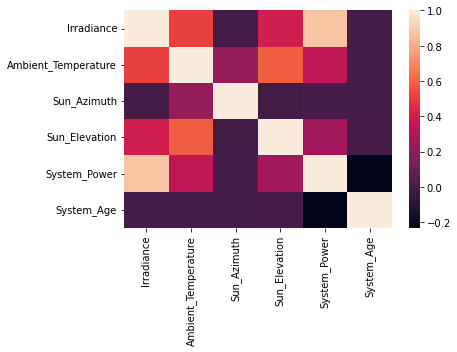

In [9]:
# Correlation matrix
corr_matrix = X_training.corr()
sn.heatmap(corr_matrix)
plt.show()

In [10]:
corr_matrix

,Irradiance,Ambient_Temperature,Sun_Azimuth,Sun_Elevation,System_Power,System_Age
Irradiance,1.000000,0.511216,-0.008649,0.399027,0.873820,-0.008066
Ambient_Temperature,0.511216,1.000000,0.230825,0.586162,0.349092,-0.007345
Sun_Azimuth,-0.008649,0.230825,1.000000,-0.010084,-0.002593,-0.009596
Sun_Elevation,0.399027,0.586162,-0.010084,1.000000,0.266748,0.003457
System_Power,0.873820,0.349092,-0.002593,0.266748,1.000000,-0.231275
System_Age,-0.008066,-0.007345,-0.009596,0.003457,-0.231275,1.000000


In [11]:
# Scaling of the features

scaler = StandardScaler()
scaler.fit(X_training)
X_training_scaled = scaler.transform(X_training)

In [12]:
# Split for binary classification

X_train, X_val, y_train, y_val = train_test_split(X_training_scaled, y_2c_training, test_size=0.15, random_state=seed_value)

In [13]:
# Polynomial features

pol = PolynomialFeatures(degree=2)
pol.fit(X_train)
X_train_pol = pol.transform(X_train)
X_val_pol = pol.transform(X_val)

# Binary Classification

## Logistic Regression

In [14]:
# Logistic Regression with original features
lr_lin = LogisticRegression(max_iter=1000)
lr_lin.fit(X_train, y_train)
y_pred = lr_lin.predict(X_val)

In [15]:
print("Logistic Regression accuracy with original features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Logistic Regression recall with original features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Logistic Regression precision with original features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Logistic Regression f1-score with original features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, lr_lin.predict(X_train))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Logistic Regression accuracy with original features: 0.6856
Logistic Regression recall with original features: 0.6824
Logistic Regression precision with original features: 0.6851
Logistic Regression f1-score with original features: 0.6838
Overfitting percentage: -1.13%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


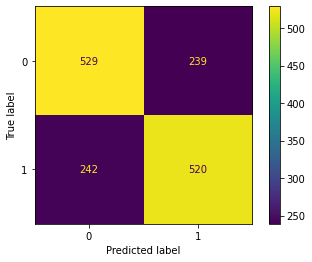

In [16]:
plot_confusion_matrix(lr_lin, X_val, y_val)

In [17]:
# Logistic Regression with polynomial features
lr_pol = LogisticRegression(max_iter=1000)
lr_pol.fit(X_train_pol, y_train)
y_pred = lr_pol.predict(X_val_pol)

In [18]:
print("Logistic Regression accuracy with polynomial features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Logistic Regression recall with polynomial features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Logistic Regression precision with polynomial features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Logistic Regression f1-score with polynomial features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, lr_pol.predict(X_train_pol))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Logistic Regression accuracy with polynomial features: 0.7712
Logistic Regression recall with polynomial features: 0.7113
Logistic Regression precision with polynomial features: 0.8065
Logistic Regression f1-score with polynomial features: 0.7559
Overfitting percentage: -2.58%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


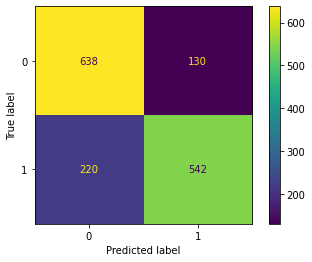

In [19]:
plot_confusion_matrix(lr_pol, X_val_pol, y_val)

## SVC

In [20]:
# Linear SVC with original features
svm_lin1 = SVC(kernel='linear')
svm_lin1.fit(X_train, y_train)
y_pred = svm_lin1.predict(X_val)

In [21]:
print("Linear SVM accuracy with original features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Linear SVM recall with original features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Linear SVM precision with original features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Linear SVM f1-score with original features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_lin1.predict(X_train))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Linear SVM accuracy with original features: 0.6915
Linear SVM recall with original features: 0.6601
Linear SVM precision with original features: 0.7025
Linear SVM f1-score with original features: 0.6806
Overfitting percentage: -2.26%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


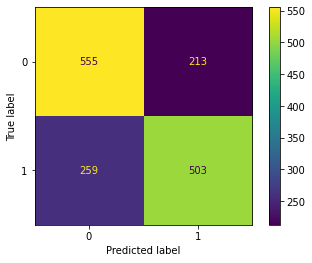

In [22]:
plot_confusion_matrix(svm_lin1, X_val, y_val)

In [23]:
# Linear SVC with polynomial features
svm_lin2 = SVC(kernel='linear')
svm_lin2.fit(X_train_pol, y_train)
y_pred = svm_lin2.predict(X_val_pol)

In [24]:
print("Linear SVM accuracy with polynomial features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Linear SVM recall with polynomial features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Linear SVM precision with polynomial features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Linear SVM f1-score with polynomial features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_lin2.predict(X_train_pol))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Linear SVM accuracy with polynomial features: 0.7634
Linear SVM recall with polynomial features: 0.6614
Linear SVM precision with polynomial features: 0.8289
Linear SVM f1-score with polynomial features: 0.7358
Overfitting percentage: -0.71%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


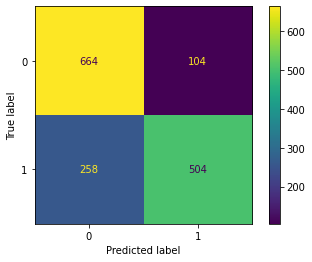

In [25]:
plot_confusion_matrix(svm_lin2, X_val_pol, y_val)

In [26]:
# Gaussian SVC with original features
svm_gauss1 = SVC(kernel='rbf')
svm_gauss1.fit(X_train, y_train)
y_pred = svm_gauss1.predict(X_val)

In [27]:
print("Gaussian SVM accuracy with original features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Gaussian SVM recall with original features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Gaussian SVM precision with original features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Gaussian SVM f1-score with original features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_gauss1.predict(X_train))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Gaussian SVM accuracy with original features: 0.7542
Gaussian SVM recall with original features: 0.6194
Gaussian SVM precision with original features: 0.8459
Gaussian SVM f1-score with original features: 0.7152
Overfitting percentage: 0.13%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


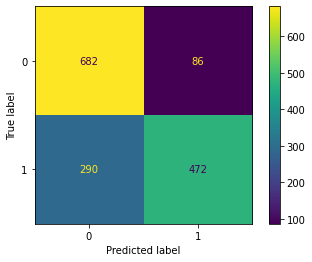

In [28]:
plot_confusion_matrix(svm_gauss1, X_val, y_val)

In [29]:
# Gaussian SVC with polynomial features
svm_gauss2 = SVC(kernel='rbf')
svm_gauss2.fit(X_train_pol, y_train)
y_pred = svm_gauss2.predict(X_val_pol)

In [30]:
print("Gaussian SVM accuracy with polynomial features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Gaussian SVM recall with polynomial features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Gaussian SVM precision with polynomial features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Gaussian SVM f1-score with polynomial features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_gauss2.predict(X_train_pol))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Gaussian SVM accuracy with polynomial features: 0.7471
Gaussian SVM recall with polynomial features: 0.5958
Gaussian SVM precision with polynomial features: 0.8518
Gaussian SVM f1-score with polynomial features: 0.7012
Overfitting percentage: 1.25%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


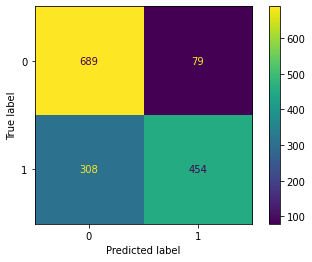

In [31]:
plot_confusion_matrix(svm_gauss2, X_val_pol, y_val)

## Weighted SVC

In [32]:
# Weighted Linear SVC with original features
weights = {0: 0.98, 1: 1.02}
svm_lin1_w = SVC(kernel='linear', class_weight=weights)
svm_lin1_w.fit(X_train, y_train)
y_pred = svm_lin1_w.predict(X_val)

In [33]:
print("Weighted Linear SVM accuracy with original features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Weighted Linear SVM recall with original features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Weighted Linear SVM precision with original features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Weighted Linear SVM f1-score with original features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_lin1_w.predict(X_train))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Weighted Linear SVM accuracy with original features: 0.6817
Weighted Linear SVM recall with original features: 0.6745
Weighted Linear SVM precision with original features: 0.6826
Weighted Linear SVM f1-score with original features: 0.6785
Overfitting percentage: -1.22%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


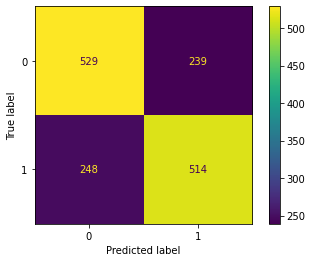

In [34]:
plot_confusion_matrix(svm_lin1_w, X_val, y_val)

In [35]:
# Weighted Linear SVC with polynomial features
weights = {0: 0.92, 1: 1.08}
svm_lin2_w = SVC(kernel='linear', class_weight=weights)
svm_lin2_w.fit(X_train_pol, y_train)
y_pred = svm_lin2_w.predict(X_val_pol)

In [36]:
print("Weighted Linear SVM accuracy with polynomial features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Weighted Linear SVM recall with polynomial features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Weighted Linear SVM precision with polynomial features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Weighted Linear SVM f1-score with polynomial features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_lin2_w.predict(X_train_pol))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Weighted Linear SVM accuracy with polynomial features: 0.7634
Weighted Linear SVM recall with polynomial features: 0.7270
Weighted Linear SVM precision with polynomial features: 0.7825
Weighted Linear SVM f1-score with polynomial features: 0.7537
Overfitting percentage: -1.75%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


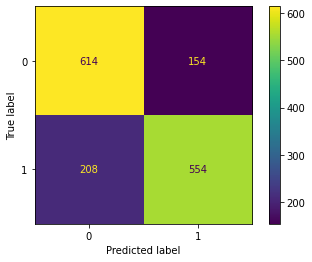

In [37]:
plot_confusion_matrix(svm_lin2_w, X_val_pol, y_val)

In [38]:
# Weighted Gaussian SVC with original features
weights = {0: 0.90, 1: 1.1}
svm_gauss1_w = SVC(kernel='rbf', class_weight=weights)
svm_gauss1_w.fit(X_train, y_train)
y_pred = svm_gauss1_w.predict(X_val)

In [39]:
print("Weighted Gaussian SVM accuracy with original features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Weighted Gaussian SVM recall with original features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Weighted Gaussian SVM precision with original features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Weighted Gaussian SVM f1-score with original features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_gauss1_w.predict(X_train))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Weighted Gaussian SVM accuracy with original features: 0.7490
Weighted Gaussian SVM recall with original features: 0.7795
Weighted Gaussian SVM precision with original features: 0.7333
Weighted Gaussian SVM f1-score with original features: 0.7557
Overfitting percentage: -0.60%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


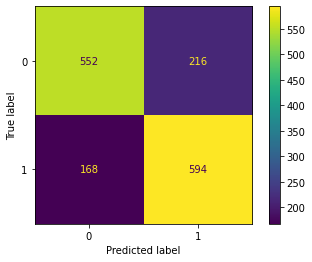

In [40]:
plot_confusion_matrix(svm_gauss1_w, X_val, y_val)

In [41]:
# Weighted Gaussian SVC with polynomial features
weights = {0: 0.90, 1: 1.1}
svm_gauss2_w = SVC(kernel='rbf', class_weight=weights)
svm_gauss2_w.fit(X_train_pol, y_train)
y_pred = svm_gauss2_w.predict(X_val_pol)

In [42]:
print("Gaussian SVM accuracy with polynomial features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Gaussian SVM recall with polynomial features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Gaussian SVM precision with polynomial features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Gaussian SVM f1-score with polynomial features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_gauss2_w.predict(X_train_pol))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Gaussian SVM accuracy with polynomial features: 0.7353
Gaussian SVM recall with polynomial features: 0.7454
Gaussian SVM precision with polynomial features: 0.7291
Gaussian SVM f1-score with polynomial features: 0.7372
Overfitting percentage: 1.88%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


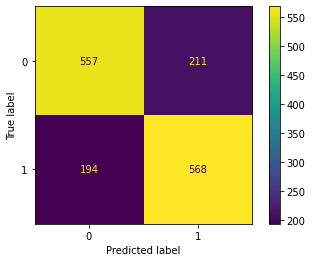

In [43]:
plot_confusion_matrix(svm_gauss2_w, X_val_pol, y_val)

## SVC Hyper Parameters Tuning

## <font color='red'>HEAVY!!!</font>

In [44]:
# Hyper Parameters tuning for Weighted Linear SVC with original features
C_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
weights = {0: 0.98, 1: 1.02}
accuracy = []
for C in C_list:
    svm_lin1_w = SVC(kernel='linear', C=C, class_weight=weights)
    svm_lin1_w.fit(X_train, y_train)
    y_pred = svm_lin1_w.predict(X_val)
    print("Accuracy with C=" + str(C) + " : {:.4f}".format(accuracy_score(y_val, y_pred)))
    accuracy.append([C, accuracy_score(y_val, y_pred)])

Accuracy with C=0.001 : 0.6307
Accuracy with C=0.01 : 0.6601
Accuracy with C=0.1 : 0.6778
Accuracy with C=1 : 0.6817
Accuracy with C=10 : 0.6843
Accuracy with C=100 : 0.6843
Accuracy with C=1000 : 0.6837


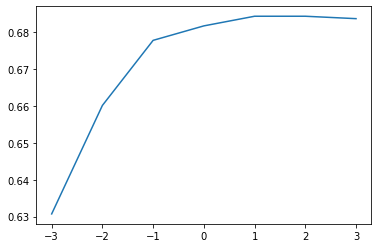

In [45]:
plt.plot(np.array(np.log10(accuracy))[:, 0], np.array(accuracy)[:, 1])

In [46]:
weights = {0: 0.98, 1: 1.02}
svm_lin1_w = SVC(kernel='linear', C=10, class_weight=weights)
svm_lin1_w.fit(X_train, y_train)
y_pred = svm_lin1_w.predict(X_val)

In [47]:
print("Weighted Linear SVM accuracy with original features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Weighted Linear SVM recall with original features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Weighted Linear SVM precision with original features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Weighted Linear SVM f1-score with original features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_lin2_w.predict(X_train_pol))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Weighted Linear SVM accuracy with original features: 0.6843
Weighted Linear SVM recall with original features: 0.6759
Weighted Linear SVM precision with original features: 0.6858
Weighted Linear SVM f1-score with original features: 0.6808
Overfitting percentage: 9.61%


## <font color='red'>HEAVY!!!</font>

In [48]:
# Hyper Parameters tuning for Weighted Linear SVC with polynomial features
#C_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
C_list = np.linspace(start=0.1, stop=1.0, num=10)
weights = {0: 0.92, 1: 1.08}
accuracy = []
for C in C_list:
    svm_lin2_w = SVC(kernel='linear', C=C, class_weight=weights)
    svm_lin2_w.fit(X_train_pol, y_train)
    y_pred = svm_lin2_w.predict(X_val_pol)
    print("Accuracy with C=" + str(C) + " : {:.4f}".format(accuracy_score(y_val, y_pred)))
    accuracy.append([C, accuracy_score(y_val, y_pred)])

Accuracy with C=0.1 : 0.7582
Accuracy with C=0.2 : 0.7614
Accuracy with C=0.30000000000000004 : 0.7634
Accuracy with C=0.4 : 0.7654
Accuracy with C=0.5 : 0.7673
Accuracy with C=0.6 : 0.7660
Accuracy with C=0.7000000000000001 : 0.7634
Accuracy with C=0.8 : 0.7621
Accuracy with C=0.9 : 0.7660
Accuracy with C=1.0 : 0.7634


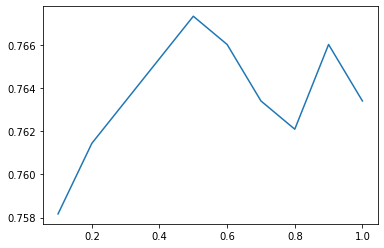

In [49]:
plt.plot(np.array(accuracy)[:, 0], np.array(accuracy)[:, 1])

In [50]:
weights = {0: 0.92, 1: 1.08}
svm_lin2_w = SVC(kernel='linear', C=0.5, class_weight=weights)
svm_lin2_w.fit(X_train_pol, y_train)
y_pred = svm_lin2_w.predict(X_val_pol)

In [51]:
print("Weighted Linear SVM accuracy with polynomial features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Weighted Linear SVM recall with polynomial features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Weighted Linear SVM precision with polynomial features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Weighted Linear SVM f1-score with polynomial features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_lin2_w.predict(X_train_pol))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Weighted Linear SVM accuracy with polynomial features: 0.7673
Weighted Linear SVM recall with polynomial features: 0.7441
Weighted Linear SVM precision with polynomial features: 0.7788
Weighted Linear SVM f1-score with polynomial features: 0.7611
Overfitting percentage: -2.43%


## <font color='red'>HEAVY!!!</font>

In [52]:
# Hyper Parameters tuning for Weighted Gaussian SVC with original features
#C_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
C_list = np.linspace(start=1000, stop=2000, num=10)
weights = {0: 0.90, 1: 1.1}
accuracy = []
for C in C_list:
    svm_gauss1_w = SVC(kernel='rbf', C=C, class_weight=weights)
    svm_gauss1_w.fit(X_train, y_train)
    y_pred = svm_gauss1_w.predict(X_val)
    print("Accuracy with C=" + str(C) + " : {:.4f}".format(accuracy_score(y_val, y_pred)))
    accuracy.append([C, accuracy_score(y_val, y_pred)])

Accuracy with C=1000.0 : 0.8255
Accuracy with C=1111.111111111111 : 0.8248
Accuracy with C=1222.2222222222222 : 0.8275
Accuracy with C=1333.3333333333335 : 0.8261
Accuracy with C=1444.4444444444443 : 0.8242
Accuracy with C=1555.5555555555557 : 0.8248
Accuracy with C=1666.6666666666667 : 0.8242
Accuracy with C=1777.7777777777778 : 0.8242
Accuracy with C=1888.888888888889 : 0.8235
Accuracy with C=2000.0 : 0.8235


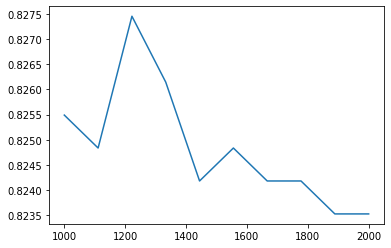

In [53]:
plt.plot(np.array(accuracy)[:, 0], np.array(accuracy)[:, 1])

In [54]:
weights = {0: 0.90, 1: 1.1}
svm_gauss1_w = SVC(kernel='rbf', C=1200, class_weight=weights)
svm_gauss1_w.fit(X_train, y_train)
y_pred = svm_gauss1_w.predict(X_val)

In [55]:
print("Weighted Gaussian SVM accuracy with original features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Weighted Gaussian SVM recall with original features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Weighted Gaussian SVM precision with original features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Weighted Gaussian SVM f1-score with original features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_lin2_w.predict(X_train_pol))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Weighted Gaussian SVM accuracy with original features: 0.8281
Weighted Gaussian SVM recall with original features: 0.8097
Weighted Gaussian SVM precision with original features: 0.8395
Weighted Gaussian SVM f1-score with original features: 0.8243
Overfitting percentage: -9.59%


## <font color='red'>HEAVY!!!</font>

In [56]:
# Hyper Parameters tuning for Weighted Gaussian SVC with polynomial features
#C_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
C_list = np.linspace(start=100, stop=1000, num=10)
weights = {0: 0.90, 1: 1.1}
accuracy = []
for C in C_list:
    svm_gauss2_w = SVC(kernel='rbf', C=C, class_weight=weights)
    svm_gauss2_w.fit(X_train_pol, y_train)
    y_pred = svm_gauss2_w.predict(X_val_pol)
    print("Accuracy with C=" + str(C) + " : {:.4f}".format(accuracy_score(y_val, y_pred)))
    accuracy.append([C, accuracy_score(y_val, y_pred)])

Accuracy with C=100.0 : 0.8150
Accuracy with C=200.0 : 0.8157
Accuracy with C=300.0 : 0.8131
Accuracy with C=400.0 : 0.8131
Accuracy with C=500.0 : 0.8203
Accuracy with C=600.0 : 0.8183
Accuracy with C=700.0 : 0.8176
Accuracy with C=800.0 : 0.8170
Accuracy with C=900.0 : 0.8157
Accuracy with C=1000.0 : 0.8131


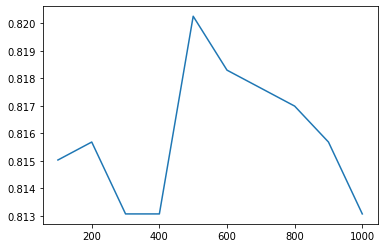

In [57]:
plt.plot(np.array(accuracy)[:, 0], np.array(accuracy)[:, 1])

In [58]:
weights = {0: 0.90, 1: 1.1}
svm_gauss2_w = SVC(kernel='rbf', C=500, class_weight=weights)
svm_gauss2_w.fit(X_train_pol, y_train)
y_pred = svm_gauss2_w.predict(X_val_pol)

In [59]:
print("Weighted Gaussian SVM accuracy with polynomial features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Weighted Gaussian SVM recall with polynomial features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Weighted Gaussian SVM precision with polynomial features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Weighted Gaussian SVM f1-score with polynomial features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, svm_lin2_w.predict(X_train_pol))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Weighted Gaussian SVM accuracy with polynomial features: 0.8203
Weighted Gaussian SVM recall with polynomial features: 0.8097
Weighted Gaussian SVM precision with polynomial features: 0.8260
Weighted Gaussian SVM f1-score with polynomial features: 0.8178
Overfitting percentage: -8.73%


## Random Forest Model

In [60]:
# Random Forest with number of estimators optimization (original dataset)

N_est = list(range(80, 210, 10)) # number of trees
accuracy = []
for N in N_est:
    rfc = RandomForestClassifier(n_estimators=N, random_state=seed_value)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_val)
    accuracy.append([N, accuracy_score(y_val, y_pred)])
    print("Accuracy with N=" + str(N) + " : {:.4f}".format(accuracy[-1][1]))

Accuracy with N=80 : 0.7876
Accuracy with N=90 : 0.7908
Accuracy with N=100 : 0.7915
Accuracy with N=110 : 0.7902
Accuracy with N=120 : 0.7895
Accuracy with N=130 : 0.7882
Accuracy with N=140 : 0.7902
Accuracy with N=150 : 0.7902
Accuracy with N=160 : 0.7895
Accuracy with N=170 : 0.7902
Accuracy with N=180 : 0.7908
Accuracy with N=190 : 0.7908
Accuracy with N=200 : 0.7863


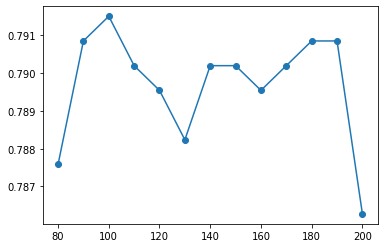

In [61]:
# Actually, there are no big changes as we increase the number of trees, we select 100 estimators
plt.plot(np.array(accuracy)[:, 0], np.array(accuracy)[:, 1])
plt.scatter(np.array(accuracy)[:, 0], np.array(accuracy)[:, 1])

In [62]:
# Random Forest with depth of tree optimization to prevent overfitting with best number of estimators (original dataset) 

N_est = 100 # number of trees
trees_depth = list(range(5, 20, 1)) # depth of the trees
accuracy_tree = []
overfit_score = []
for depth in trees_depth:
    rfc = RandomForestClassifier(n_estimators=N_est, random_state=seed_value, max_depth=depth)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_val)
    accuracy_tree.append([depth, accuracy_score(y_val, y_pred)])
    overfit_score.append([depth, (accuracy_score(y_train, rfc.predict(X_train))/accuracy_score(y_val, y_pred)) - 1])
    print("Accuracy with depth=" + str(depth) + " : {:.4f}".format(accuracy_tree[-1][1]))
    print("Overfit with depth=" + str(depth) + " : {:.4f}".format(overfit_score[-1][1]))

Accuracy with depth=5 : 0.7144
Overfit with depth=5 : 0.0133
Accuracy with depth=6 : 0.7359
Overfit with depth=6 : 0.0209
Accuracy with depth=7 : 0.7340
Overfit with depth=7 : 0.0406
Accuracy with depth=8 : 0.7458
Overfit with depth=8 : 0.0559
Accuracy with depth=9 : 0.7510
Overfit with depth=9 : 0.0796
Accuracy with depth=10 : 0.7451
Overfit with depth=10 : 0.1096
Accuracy with depth=11 : 0.7523
Overfit with depth=11 : 0.1317
Accuracy with depth=12 : 0.7647
Overfit with depth=12 : 0.1522
Accuracy with depth=13 : 0.7667
Overfit with depth=13 : 0.1838
Accuracy with depth=14 : 0.7791
Overfit with depth=14 : 0.2029
Accuracy with depth=15 : 0.7791
Overfit with depth=15 : 0.2209
Accuracy with depth=16 : 0.7850
Overfit with depth=16 : 0.2341
Accuracy with depth=17 : 0.7732
Overfit with depth=17 : 0.2701
Accuracy with depth=18 : 0.7758
Overfit with depth=18 : 0.2753
Accuracy with depth=19 : 0.7869
Overfit with depth=19 : 0.2637


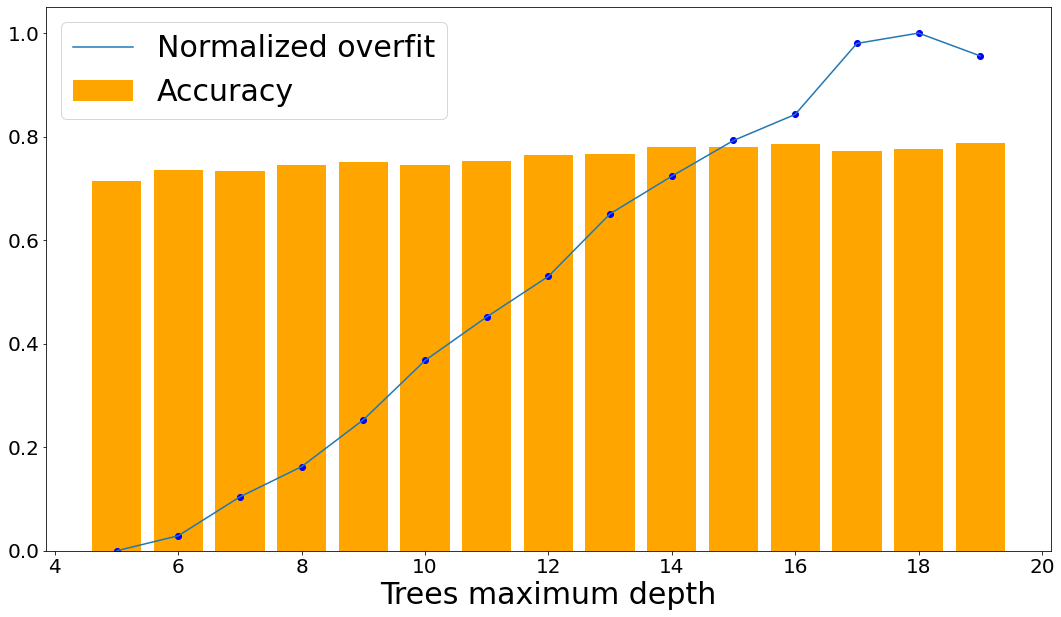

In [63]:
# Plot of accuracy and overfit (with max-min normalization to best interpret the plot)
normalized_overfit = (np.array(overfit_score)[:, 1] - np.amin(np.array(overfit_score)[:, 1]))/(np.amax(np.array(overfit_score)[:, 1]) - np.amin(np.array(overfit_score)[:, 1]))

plt.figure(figsize=(18,10))
plt.plot(trees_depth, normalized_overfit, label='Normalized overfit')
plt.bar(trees_depth, np.array(accuracy_tree)[0:len(trees_depth), 1], color='orange', label='Accuracy')
plt.scatter(trees_depth, normalized_overfit, color='blue')

plt.xlabel('Trees maximum depth', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=30)

plt.savefig('Trees.png')

In [64]:
rfc = RandomForestClassifier(n_estimators=100, random_state=seed_value, max_depth=14)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)

In [65]:
print("Random Forest accuracy with original features: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Random Forest recall with original features: {:.4f}".format(recall_score(y_val, y_pred)))
print("Random Forest precision with original features: {:.4f}".format(precision_score(y_val, y_pred)))
print("Random Forest f1-score with original features: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, rfc.predict(X_train))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Random Forest accuracy with original features: 0.7791
Random Forest recall with original features: 0.7651
Random Forest precision with original features: 0.7857
Random Forest f1-score with original features: 0.7753
Overfitting percentage: 20.29%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


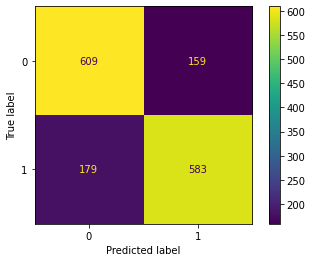

In [66]:
plot_confusion_matrix(rfc, X_val, y_val)

## Feed Forward Neural Networks

In [67]:
set_seed(4720) # IMPORTANT: this guarantees repeatability

In [68]:
# Function to build the network with Keras

def buildNetwork(layers, nodes, regularization=0.0, dropout_factor=0.0):
    input_nodes = 6
    output_nodes = 1
    model = Sequential()
    if (dropout_factor > 0.0 and dropout_factor < 1.0):
            model.add(Dropout(dropout_factor, input_shape=(input_nodes,)))
    model.add(Dense(nodes[0], input_dim=input_nodes, activation='relu')) # add the first layer: from input layer to first layer
    for i in range(1, layers):
        if (dropout_factor > 0.0 and dropout_factor < 1.0):
            model.add(Dropout(dropout_factor, input_shape=(nodes[i-1],)))
        model.add(Dense(nodes[i], activation='relu', kernel_regularizer=regularizers.l2(regularization)))
    model.add(Dense(output_nodes, activation='sigmoid')) # Important: dropout is not used on the output layer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # training the network
    return model

In [69]:
# To print the neural network

def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers


'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    #plt.savefig('NN.png')
    plt.show()

In [70]:
# Neural networks architectures: list of [number_of_layers, [nodes]]

NN_architecture = [[2, [9, 8]], [2, [8, 7]], [2, [7, 6]], [2, [6, 6]],
                   [3, [9, 9, 9]], [3, [9, 9, 8]], [3, [8, 8, 7]], [3, [6, 6, 6]], [3, [6, 6, 5]],
                   [4, [9, 9, 8, 8]], [4, [9, 9, 8, 7]], [4, [8, 8, 8, 7]], [4, [7, 7, 7, 6]], [4, [6, 6, 6, 6]]]

## <font color='red'>HEAVY!!!</font>

In [71]:
# Training of different neural networks with cross validation and early stopping (without regularization and dropout)
n_epochs = 5000
accuracy = []
for shape in NN_architecture:
    print("Neural network shape: ", shape[0], shape[1])
    set_seed(4720)
    NN_model = buildNetwork(shape[0], shape[1])
    early_stopping = EarlyStopping(monitor='val_accuracy', mode='auto', patience=50, verbose=1)
    history = NN_model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    model_accuracy = np.amax(history.history['val_accuracy'])
    accuracy.append([shape, model_accuracy])
    print("Accuracy: {:.4f}".format(model_accuracy))
    #visualize_nn(NN_model)

Neural network shape:  2 [9, 8]


2022-10-23 16:22:15.310152: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-23 16:22:15.508887: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 00365: early stopping
Accuracy: 0.8523
Neural network shape:  2 [8, 7]
Epoch 00153: early stopping
Accuracy: 0.8294
Neural network shape:  2 [7, 6]
Epoch 00303: early stopping
Accuracy: 0.8353
Neural network shape:  2 [6, 6]
Epoch 00185: early stopping
Accuracy: 0.8190
Neural network shape:  3 [9, 9, 9]
Epoch 00198: early stopping
Accuracy: 0.8458
Neural network shape:  3 [9, 9, 8]
Epoch 00330: early stopping
Accuracy: 0.8477
Neural network shape:  3 [8, 8, 7]
Epoch 00135: early stopping
Accuracy: 0.8281
Neural network shape:  3 [6, 6, 6]
Epoch 00142: early stopping
Accuracy: 0.8229
Neural network shape:  3 [6, 6, 5]
Epoch 00275: early stopping
Accuracy: 0.8301
Neural network shape:  4 [9, 9, 8, 8]
Epoch 00208: early stopping
Accuracy: 0.8444
Neural network shape:  4 [9, 9, 8, 7]
Epoch 00264: early stopping
Accuracy: 0.8412
Neural network shape:  4 [8, 8, 8, 7]
Epoch 00186: early stopping
Accuracy: 0.8320
Neural network shape:  4 [7, 7, 7, 6]
Epoch 00233: early stopping
Accuracy:

[0.8522875905036926 0.8294117450714111 0.8352941274642944
 0.8189542293548584 0.8457516431808472 0.8477123975753784
 0.828104555606842 0.8228757977485657 0.8300653696060181
 0.8444444537162781 0.841176450252533 0.8320261240005493
 0.8366013169288635 0.842483639717102]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

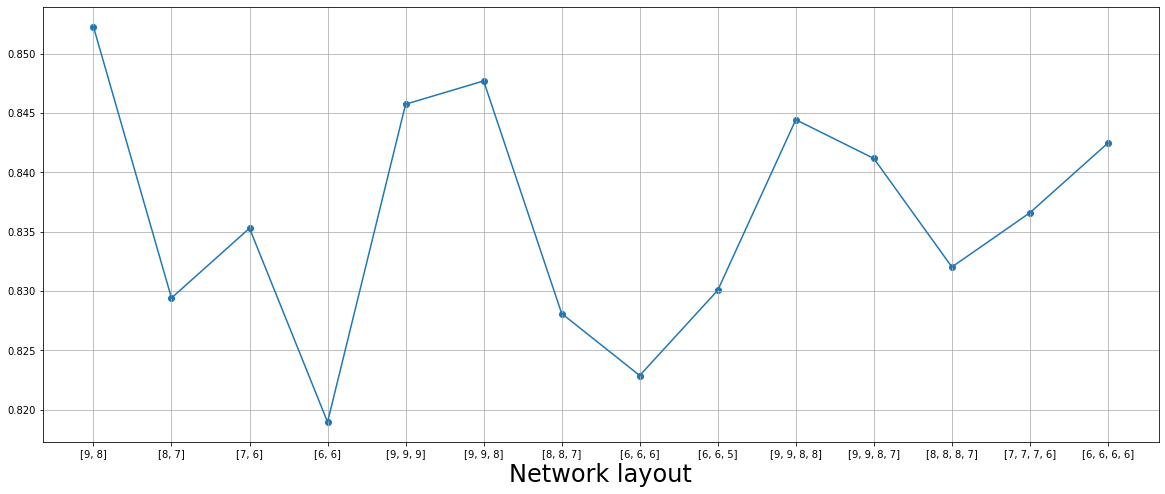

In [72]:
print(np.array(accuracy)[:, 1])
plt.figure(figsize=(20,8))
plt.plot(range(0, len(NN_architecture)), np.array(accuracy)[:, 1])
plt.scatter(range(0, len(NN_architecture)), np.array(accuracy)[:, 1])
plt.xticks(ticks=range(0, len(NN_architecture)), labels=[j for i, j in NN_architecture])
plt.xlabel('Network layout',fontsize=24)
plt.grid()

## K-fold Cross Validation

## <font color='red'>HEAVY!!!</font>

In [73]:
# Create the K splits with StratifiedKFold() to preserve the classes ratio in the split
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed_value)
# Compute the K-fold Cross Validation Accuracy for all the models

models = [lr_lin, svm_lin1_w, svm_gauss1_w, rfc]
accuracy_list = []
for model in models:
    scores = cross_val_score(model, X_training_scaled, y_2c_training, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    accuracy_list.append(np.mean(scores))

In [74]:
# k-fold cross validation for neural networks (on four best performing network for computational cost reasons)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)
n_epochs = 5000
accuracy_list_nn = []
NN_best_architecture = [[2, [9, 8]], [3, [9, 9, 9]], [3, [9, 9, 8]], [4, [9, 9, 8, 8]]]
for shape in NN_best_architecture:
    accuracy_scores = []
    print("Neural network shape: ", shape[0], shape[1])
    fold = 1
    for train, val in kfold.split(np.array(X_training_scaled), np.array(y_2c_training)):
        print("Fold = ", fold)
        set_seed(4720)
        NN_model = buildNetwork(shape[0], shape[1])
        early_stopping = EarlyStopping(monitor='val_accuracy', mode='auto', patience=50, verbose=1)
        history = NN_model.fit(np.array(X_training_scaled)[train], np.array(y_2c_training)[train], 
                                epochs=5000, batch_size=32, verbose=0, 
                                validation_data=(np.array(X_training_scaled)[val], np.array(y_2c_training)[val]), callbacks=[early_stopping])
        model_accuracy = np.amax(history.history['val_accuracy'])
        accuracy_scores.append([model_accuracy])
        fold += 1
    accuracy_list_nn.append(np.mean(accuracy_scores))
    print("Accuracy: {:.4f}".format(accuracy_list_nn[-1]))


Neural network shape:  2 [9, 8]
Fold =  1
Epoch 00220: early stopping
Fold =  2
Epoch 00240: early stopping
Fold =  3
Epoch 00158: early stopping
Fold =  4
Epoch 00116: early stopping
Fold =  5
Epoch 00151: early stopping
Accuracy: 0.8265
Neural network shape:  3 [9, 9, 9]
Fold =  1
Epoch 00189: early stopping
Fold =  2
Epoch 00252: early stopping
Fold =  3
Epoch 00321: early stopping
Fold =  4
Epoch 00232: early stopping
Fold =  5
Epoch 00218: early stopping
Accuracy: 0.8388
Neural network shape:  3 [9, 9, 8]
Fold =  1
Epoch 00274: early stopping
Fold =  2
Epoch 00360: early stopping
Fold =  3
Epoch 00125: early stopping
Fold =  4
Epoch 00264: early stopping
Fold =  5
Epoch 00149: early stopping
Accuracy: 0.8311
Neural network shape:  4 [9, 9, 8, 8]
Fold =  1
Epoch 00445: early stopping
Fold =  2
Epoch 00229: early stopping
Fold =  3
Epoch 00143: early stopping
Fold =  4
Epoch 00397: early stopping
Fold =  5
Epoch 00312: early stopping
Accuracy: 0.8415


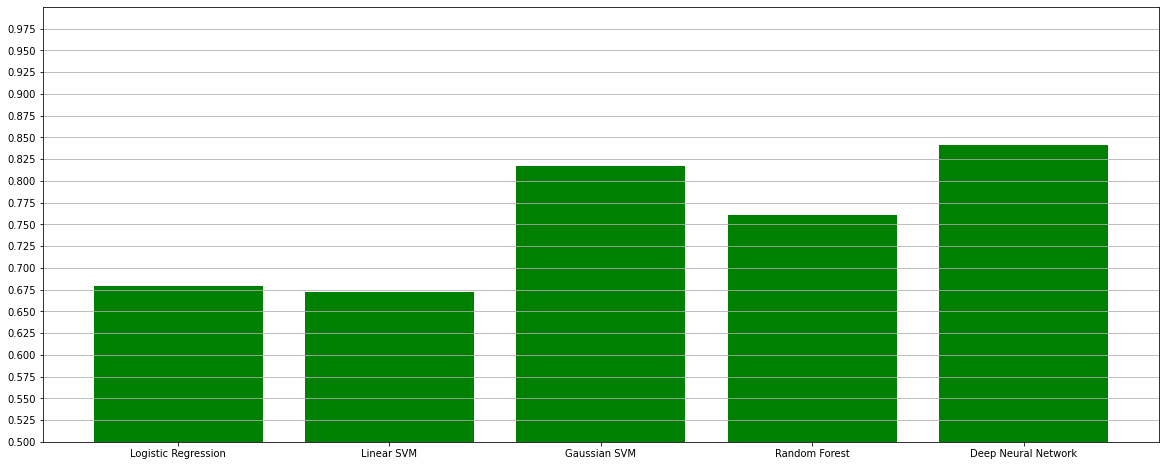

In [75]:
model_names = ['Logistic Regression', 'Linear SVM', 
               'Gaussian SVM', 'Random Forest', 'Deep Neural Network']
accuracy_list_with_NN = accuracy_list + [max(accuracy_list_nn)]
plt.figure(figsize=(20, 8))
plt.bar(model_names, accuracy_list_with_NN, color='green')
plt.ylim(0.5, 1.0)
plt.yticks(np.arange(0.5, 1.0, 0.025))
plt.grid(axis='y')

In [76]:
for i, model in enumerate(model_names):
    print('Accuracy of ' + str(model) + ' = {:.4f}'.format(accuracy_list_with_NN[i]))

Accuracy of Logistic Regression = 0.6795
Accuracy of Linear SVM = 0.6727
Accuracy of Gaussian SVM = 0.8172
Accuracy of Random Forest = 0.7612
Accuracy of Deep Neural Network = 0.8415


## Testing

In [77]:
# Best model training
from keras.callbacks import ModelCheckpoint
set_seed(4720)
filepath="DeepNN.hdf5"
NN_model = buildNetwork(4, [9, 9, 8, 8])
early_stopping = EarlyStopping(monitor='val_accuracy', mode='auto', patience=50, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
NN_model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, verbose=0, 
                       validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint])


Epoch 00001: val_accuracy improved from -inf to 0.58105, saving model to DeepNN.hdf5

Epoch 00002: val_accuracy improved from 0.58105 to 0.66078, saving model to DeepNN.hdf5

Epoch 00003: val_accuracy improved from 0.66078 to 0.69346, saving model to DeepNN.hdf5

Epoch 00004: val_accuracy improved from 0.69346 to 0.70719, saving model to DeepNN.hdf5

Epoch 00005: val_accuracy did not improve from 0.70719

Epoch 00006: val_accuracy did not improve from 0.70719

Epoch 00007: val_accuracy improved from 0.70719 to 0.72222, saving model to DeepNN.hdf5

Epoch 00008: val_accuracy improved from 0.72222 to 0.72418, saving model to DeepNN.hdf5

Epoch 00009: val_accuracy improved from 0.72418 to 0.73137, saving model to DeepNN.hdf5

Epoch 00010: val_accuracy improved from 0.73137 to 0.74183, saving model to DeepNN.hdf5

Epoch 00011: val_accuracy improved from 0.74183 to 0.74837, saving model to DeepNN.hdf5

Epoch 00012: val_accuracy improved from 0.74837 to 0.75098, saving model to DeepNN.hdf5



In [78]:
NN_model.load_weights("DeepNN.hdf5")
y_pred = np.where(NN_model.predict(X_val) < 0.5, 0, 1)
print("Deep NN accuracy: {:.4f}".format(accuracy_score(y_val, y_pred)))
print("Deep NN recall: {:.4f}".format(recall_score(y_val, y_pred)))
print("Deep NN precision: {:.4f}".format(precision_score(y_val, y_pred)))
print("Deep NN f1-score: {:.4f}".format(f1_score(y_val, y_pred)))
overfitting = (accuracy_score(y_train, rfc.predict(X_train))/accuracy_score(y_val, y_pred)) - 1
print("Overfitting percentage: {:.2f}%".format(overfitting*100))

Deep NN accuracy: 0.8444
Deep NN recall: 0.7835
Deep NN precision: 0.8910
Deep NN f1-score: 0.8338
Overfitting percentage: 10.98%


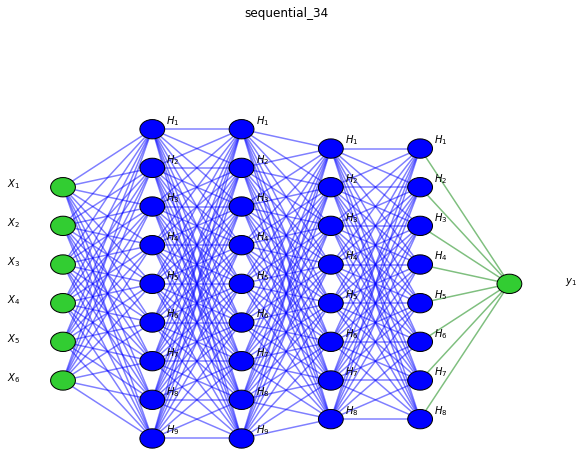

In [79]:
visualize_nn(NN_model)

In [80]:
# Test
X_test_scaled = scaler.transform(X_test)
y_pred_test = np.where(NN_model.predict(X_test_scaled) < 0.5, 0, 1)

In [81]:
print("Test accuracy: {:.4f}".format(accuracy_score(y_2c_test, y_pred_test)))
print("Test recall: {:.4f}".format(recall_score(y_2c_test, y_pred_test)))
print("Test precision: {:.4f}".format(precision_score(y_2c_test, y_pred_test)))
print("Test f1-score: {:.4f}".format(f1_score(y_2c_test, y_pred_test)))

Test accuracy: 0.8289
Test recall: 0.7724
Test precision: 0.8678
Test f1-score: 0.8173


# Multi Classification

## First Part

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, plot_roc_curve, confusion_matrix, plot_confusion_matrix 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
import shap

In [ ]:
y_1d=data_orig.iloc[:,7]

if i keep the same random state it will be the same split of the one-hot encoded y

In [ ]:
y_1d_train, y_1d_test = train_test_split(y_1d, test_size=0.15, random_state=4720)

In [ ]:
X_train, X_val, y_train_mc, y_val_mc = train_test_split(X_training_scaled, y_1d_train, test_size=0.15, random_state=4720)
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures(degree=3)
pol.fit(X_train)
X_train_pol = pol.transform(X_train)
X_val_pol = pol.transform(X_val)

In [ ]:
class_weight={0:0.9,1:1.3,2:1.5,3:1}
lr = LogisticRegression(multi_class='multinomial',max_iter=1000,class_weight=class_weight)
y_pred = lr.fit(X_train, y_train_mc).predict(X_val)
print("Accuracy:", accuracy_score(y_val_mc, y_pred))

Accuracy: 0.6320261437908496


In [ ]:
class_weight={0:0.9,1:1.3,2:1.5,3:1}
lr_pol = LogisticRegression(multi_class='multinomial',max_iter=1000,class_weight=class_weight)
y_pred_pol = lr_pol.fit(X_train_pol, y_train_mc).predict(X_val_pol)
print("Accuracy pol:", accuracy_score(y_val_mc, y_pred_pol))

Accuracy pol: 0.7196078431372549


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


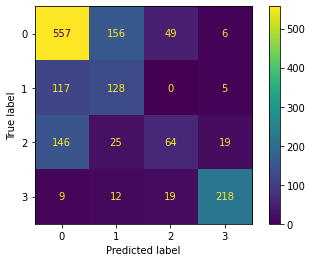

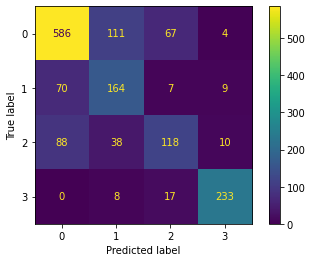

In [ ]:
plot_confusion_matrix(lr,X_val,y_val_mc)
plot_confusion_matrix(lr_pol,X_val_pol,y_val_mc)

In [ ]:
rfc = RandomForestClassifier(n_estimators=90)
y_pred = rfc.fit(X_train, y_train_mc).predict(X_val)
print("Accuracy:", accuracy_score(y_val_mc, y_pred))  

Accuracy: 0.7111111111111111


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


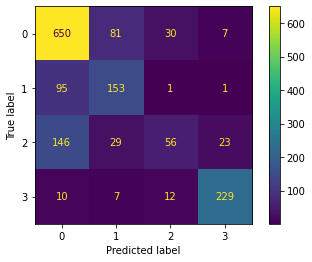

In [ ]:
plot_confusion_matrix(rfc,X_val,y_val_mc)

In [ ]:
C_list=[750,800,850]
for i in C_list:
    clf_svmgauss = svm.SVC(kernel='rbf',C=i).fit(X_train, y_train_mc)
    y_prediction_svmguass = clf_svmgauss.predict(X_val)
    Accuracy_svmG = accuracy_score(y_val_mc,y_prediction_svmguass)
    print("Accuracy with linear features: " + str(Accuracy_svmG))

Accuracy with linear features: 0.7810457516339869
Accuracy with linear features: 0.7830065359477124
Accuracy with linear features: 0.7823529411764706


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


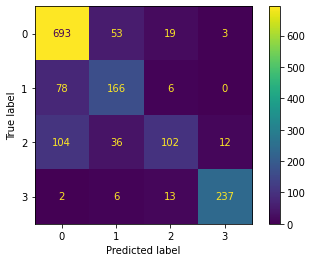

In [ ]:
clf_svmgauss = svm.SVC(kernel='rbf',C=800).fit(X_train, y_train_mc)
plot_confusion_matrix(clf_svmgauss,X_val,y_val_mc)

In [ ]:
C_list=[700,800,900]
for i in C_list:
    clf_svmgauss = svm.SVC(kernel='rbf',C=i).fit(X_train_pol, y_train_mc)
    y_prediction_svmguass = clf_svmgauss.predict(X_val_pol)
    Accuracy_svmG = accuracy_score(y_val_mc,y_prediction_svmguass)
    print("Accuracy with polynomial features: " + str(Accuracy_svmG))

Accuracy with polynomial features: 0.7601307189542483
Accuracy with polynomial features: 0.7633986928104575
Accuracy with polynomial features: 0.7640522875816993


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


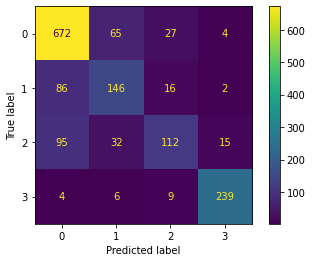

In [ ]:
clf_svmgauss_pol = svm.SVC(kernel='rbf',C=900).fit(X_train_pol, y_train_mc)
plot_confusion_matrix(clf_svmgauss_pol,X_val_pol,y_val_mc)


In [ ]:
bag = BaggingClassifier(base_estimator=svm.SVC(kernel='rbf',C=800, coef0=0.0, tol=1e-3),n_estimators=10, random_state=0)
y_pred = bag.fit(X_train, y_train_mc).predict(X_val)
print("Accuracy:", accuracy_score(y_val_mc, y_pred))

Accuracy: 0.7705882352941177


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


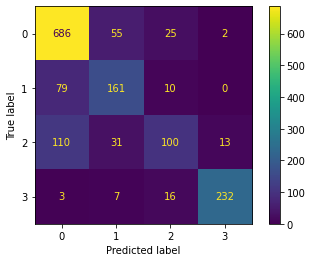

In [ ]:
plot_confusion_matrix(bag,X_val,y_val_mc)

## Deep neural network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dropout

In [ ]:
# Function to build the network with Keras for Multiclass classification

def buildNetwork(layers, nodes, regularization=0.0, dropout_factor=0.0):
    input_nodes = 6
    output_nodes = 4
    model = Sequential()
    if (dropout_factor > 0.0 and dropout_factor < 1.0):
            model.add(Dropout(dropout_factor, input_shape=(input_nodes,)))
    model.add(Dense(nodes[0], input_dim=input_nodes, activation='relu')) # add the first layer: from input layer to first layer
    for i in range(1, layers):
        if (dropout_factor > 0.0 and dropout_factor < 1.0):
            model.add(Dropout(dropout_factor, input_shape=(nodes[i-1],)))
        model.add(Dense(nodes[i], activation='relu', kernel_regularizer=regularizers.l2(regularization)))
    model.add(Dense(output_nodes, activation='softmax')) # Important: dropout is not used on the output layer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # training the network
    return model

In [ ]:
layers=3
nodes=[6,10,6]
model=buildNetwork(layers,nodes)

In [ ]:
X_train, X_val,y_train_mc, y_val_mc = train_test_split(X_training_scaled,y_mc_training, test_size=0.15, random_state=4720)

In [ ]:
history = model.fit(X_train, y_train_mc, epochs=620, batch_size=10)

867/867 [==============================] - 2s 2ms/step - loss: 0.4603 - accuracy: 0.8016


In [ ]:
# evaluate the keras model
_,accuracy = model.evaluate(X_val, y_val_mc)   
print('Accuracy:')
print(accuracy)

48/48 [==============================] - 0s 3ms/step - loss: 0.4783 - accuracy: 0.8013
Accuracy:
0.801307201385498


In [ ]:
y_mc_predict=model.predict(X_val,batch_size=10)
matrix = confusion_matrix(np.array(y_val_mc).argmax(axis=1), y_mc_predict.argmax(axis=1))
matrix

array([[688,  60,  18,   2],
       [ 71, 174,   4,   1],
       [ 94,  27, 119,  14],
       [  1,   8,   4, 245]], dtype=int64)

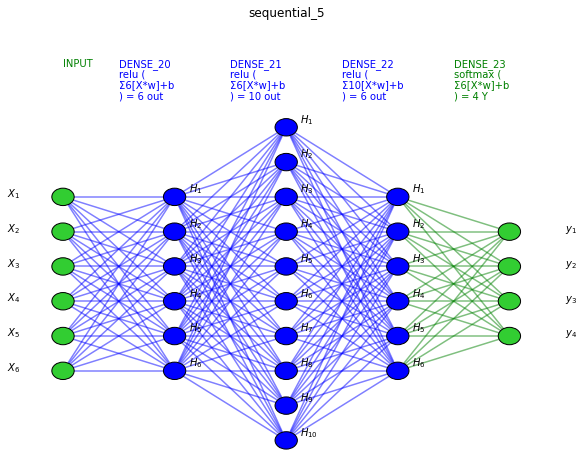

In [ ]:
visualize_nn(model, description=True, figsize=(10,8))

## SHAP

In [ ]:
explainer = shap.DeepExplainer(model,X_train)
shap_values = explainer.shap_values(X_val)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


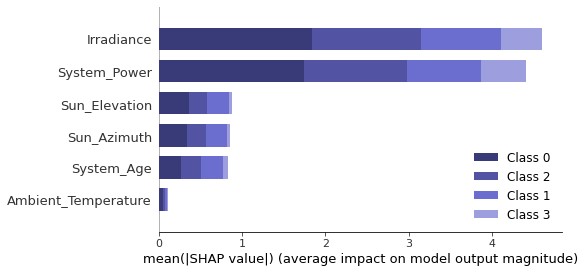

In [ ]:
import matplotlib.pyplot as pl
shap.summary_plot(shap_values, X_val, plot_type="bar",feature_names=list(X_training.columns),color=pl.get_cmap("tab20b"))

## Testing

In [ ]:
# Scaling of the features

scaler = StandardScaler()
scaler.fit(X_testing)
X_testing_scaled = scaler.transform(X_testing)

In [ ]:
pred=model.predict(X_testing_scaled)
accuracy = accuracy_score(np.array(y_mc_test).argmax(axis=1),pred.argmax(axis=1))
print('Accuracy: %.2f' % (accuracy*100))
matrix = confusion_matrix(np.array(y_mc_test).argmax(axis=1), pred.argmax(axis=1))
matrix

Accuracy: 79.78


array([[797,  69,  42,   0],
       [ 90, 205,  11,   5],
       [ 99,  23, 151,  15],
       [  0,   6,   4, 283]], dtype=int64)